# Twitter

Last updated 20160823

## T.1 학습내용

### T.1.1 목표

* OAuth인증을 사용할 수 있다.
* Twitter API를 사용하여 글을 쓰고, 읽고, 검색할 수 있다.
* 트윗을 저장한다.

### T.1.2 문제

* T-1: Twitter에 'Hello World'를 쓴다.
    * save json
* T-2: Twitter에서 자신의 타임라인 가져오기
    * 2개만 (count)
    * 특정 시점 (max_id, since_id)
    * 모두 가져오기
    * mongo save
* T-3: Twitter에 'Seoul'을 10개 검색한다.
* T-4: Twitter에 'Seoul'을 2015년 12월 한 달 분량을 읽는다.
* T-5: Follower를 가져온다.
* T-6: Follower의 timeline을 가져온다.
* T-7: 트렌드 읽기
* T-8: write to a file (or db)
* T-9: WordCloud

### T.1.3 연습

* 읽어와서 단어별로 빈도 그래프


## S.2 소개

### S.2.1 SNS 크롤링

* SNS는 Social Network Service로 사람과 사람들이 관계를 가지고, 서로 자신들의 의견이나 활동과 같이 하고 싶은 얘기를 하는 사이트. Twitter, Facebook과 같은 소셜미디어를 예로 들 수 있다.
* SNS 데이터를 API로 가져와 의미있는 정보를 분석하는 작업
* 사용할 수 있는 라이브러리
    * twitter
        ```
        pip install twitter
        ```

    * [python-oauth2](https://github.com/joestump/python-oauth2/wiki/)
        * httplib2를 사용하는 방식과 유사
        ```
        pip install oauth2 
        ```

    * urllib2
    * requests
    * curl - Terminal에서 사용하는 명령어


### S.2.2 데이터량 제한 Rate limit

* Twitter 데이터를 가져오는 방법
    * 1 Twitter’s Search API
    * 2 Streaming API - at most 1% (not random)
    ```
    http://stackoverflow.com/questions/17319788/using-python-and-oauth2-with-twitter-streaming-api
    ```

    * 3 Firehose - a paid service 유료, 모든 트윗을 가져올 수 있다.
* Twitter’s rate limits (the number of calls it allows each user to make) fall into two categories:
    * 15 calls per 15-minute period, and
    * 180 calls per 15-minute period, depending on the type of call.
    * API_KEY, API_SECRET - 'Application only Auth' - 450 request/sec (maximum 100 tweets per request), this gives a rate of 45,000 tweets/15-min, which is 2.5 times more than the Access Token Limit.


### S.2.3 OAuth

* Authorization
    * http basic
        * 사용자계정, 비밀번호로 로그인
        * 사용자 비밀번호가 공개되어 보안에 취약하며, 권한 제어가 되지 않아 무제한 사용 가능한 문제
        * https를 사용할 수 있다.
    ```
    http://site.com/api/sync?username=user_name&password=user_pass&args=args
    ```
    * OAuth OAuth Open Authentication Protocol
        * Twitter에 요청해서 App에 access token을 물어보는 방식

* signature
    * generate an OAuth 1.0a HMAC-SHA1 signature for a HTTP request.
    * This signature will be suitable for passing to the Twitter API as part of an authorized request

* Authentication 사용자 인증
    * consumer key, consumer secret
    * access token, access token secret

* 3 legged vs 2 legged
    * 양자 vs 3자 방식: leg는 개입하는 역할을 의미.
    * 3자 방식
        * end-user (or resource owner)
        * consumer (the third-party application) - 여기에 억세스토큰만 전달됨
        * service provider (or authorization server) - e.g., Twitter, Facebook
        ```
        client = oauth.Client(consumer, token)
        ```

    * 양자 방식 - end-user 제외
        * a simple client-server authenticated request - client의 customer key, customer secret을 사용해서 사인하는 방식
        * access token or access token secret을 사용하지 않음.
        * oauth2.Token is only needed for three-legged requests

        ```
        client = oauth.Client(consumer)
        ```

* endpoint
    * 서버의 사용하려는 서비스 url
    * 사용자 요청이 끝나는 API url


* 프로세스
    * 사용자가 트위터앱을 사용함
    * 트위터앱은 트위터 (서비스 제공자)에게 로그인을 요청
    * 트위터 (서비스 제공자)는 사용자에게 로그인페이지를 돌려줌.
    * 트위터 (서비스 제공자)는 트위어앱에 'access token'을 제공함.

* end-user는 나중에 마음에 들지 않는 권한을 취소할 수 있다.
* 앱의 access token을 revoke할 수 있다.

In [1]:
import iplantuml

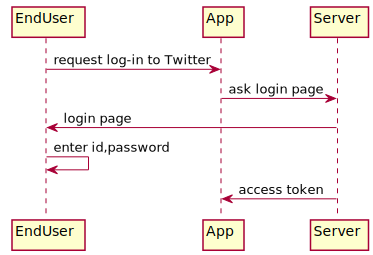

In [2]:
%%plantuml
@startuml
EndUser -> App: request log-in to Twitter
App -> Server: ask login page
Server -> EndUser : login page
EndUser -> EndUser : enter id,password
Server -> App: access token
@enduml

## 트위터 키 설정하기

* [트위터](https://twitter.com) 회원가입을 하고, 자신의 계정을 만든다.
* apps.twitter.com로 가서
* "Create New App" 앱을 생성한다.
* 앱의 이름, 설명을 입력
* 앱의 웹사이트를 입력 - 앱이 실행될 호스트. 없으면 임시로 넣는다. 또는 https://twitter.com

* "Keys and Access Tokens"를 누른다.
* "Create my access token"

* 2개의 키가 필요 - consumer, token

* 파일에 저장된 key를 사용한다.
    * java twitter4j에서 사용하는 twitter4j.properties 파일을 사용한다.
    * 첫 줄은 의미가 없으므로 버리고,
    * 나머지 줄은 '.' 뒤를 대문자로 바꾸어서 사용한다. line을 읽을 때 '\n'을 제거한다.

In [1]:
def getApiKey(keyPath):
    d=dict()
    f=open(keyPath,'r')
    for line in f.readlines():
        row=line.split('=')
        if(row[0]!='debug'):
            row0=row[0].split('.')
            d[row0[1].upper()]=row[1].strip()
    return d

In [2]:
import os

keyPath=os.path.join(os.path.expanduser("~"),'Code/git/bb/sd','twitter4j.properties')
key=getApiKey(keyPath)

## T-1: Twitter에 'Hello World'를 쓴다.

* 트위터 API문서 참조
    * statuses.update
    * https://dev.twitter.com/rest/reference/post/statuses/update
    * Parameters
        * 반드시 입력해야 하는 항목 ('required') -> status
    * 결과는 JSON
    * 주의: OAuth Signature가 있어야 함.

### Twitter 라이브러리 

In [5]:
import twitter

auth = twitter.oauth.OAuth(key['ACCESSTOKEN'],key['ACCESSTOKENSECRET'],
                            key['CONSUMERKEY'], key['CONSUMERSECRET'])
_client = twitter.Twitter(auth=auth)
print _client

In [43]:
_client.statuses.update(status="Hello Twitter 1 160924")

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Sat Sep 24 08:59:47 +0000 2016',
 u'entities': {u'hashtags': [],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': None,
 u'id': 779606243950211072,
 u'id_str': u'779606243950211072',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'no',
 u'place': None,
 u'retweet_count': 0,
 u'retweeted': False,
 u'source': u'<a href="http://jsl.com/" rel="nofollow">JSL</a>',
 u'text': u'Hello Twitter 2016-09-24 18:01',
 u'truncated': False,
 u'user': {u'contributors_enabled': False,
  u'created_at': u'Sun Sep 19 00:44:43 +0000 2010',
  u'default_profile': True,
  u'default_profile_image': False,
  u'description': u'\uc0c1\uba85\ub300',
  u'entities': {u'description': {u'urls': []}},
  u'favourites_count': 1,
  u'fol

### OAuth2


In [4]:
import oauth2 as oauth
import json

consumer = oauth.Consumer(key=key['CONSUMERKEY'], secret=key['CONSUMERSECRET'])
token=oauth.Token(key=key['ACCESSTOKEN'], secret=key['ACCESSTOKENSECRET'])

In [5]:
client = oauth.Client(consumer, token)

In [7]:
help(client.request)

Help on method request in module oauth2:

request(self, uri, method='GET', body='', headers=None, redirections=5, connection_type=None) method of oauth2.Client instance



* POST
    * body param은 post에만 사용할 수 있다??
    * GET방식의 param은 url에 ?다음 붙여서 사용

In [73]:
import urllib
url = "https://api.twitter.com/1.1/statuses/update.json"
mybody=urllib.urlencode({'status': 'Hello 21 160924'})
response,content=client.request(url,method='POST',body=mybody)

* save
    * csv
    * json
* io모듈
    * Python 3을 대상으로 만들어진 모듈, python 2.에서는 file 대신

In [76]:
import io
with io.open('src/ds_twitter_1.json', 'w', encoding='utf8') as json_file:
    data=json.dumps(content, json_file, ensure_ascii=False, encoding='utf8')
    json_file.write(data)

## T-2: 자신의 타임라인 가져오기

* 2개만 (count)
* 특정 시점 (max_id, since_id)
* 모두 가져오기


* GET statuses/home_timeline
    * 사용자와 그 친구들이 올리는 트윗과 리트윗을 가져옴
    * 800개 제한
    * 입력변수는 선택적
    * 출력은 JSON

```
user_timeline = client.statuses.user_timeline(screen_name='jslimit')
```

### Twitter  라이브러리

In [6]:
timeline = _client.statuses.home_timeline()

In [19]:
print type(timeline)
print len(timeline)

<class 'twitter.api.TwitterListResponse'>
20


In [24]:
print type(timeline[0])
for key in timeline[0].keys():
    print key,timeline[0][key]

<type 'dict'>
contributors None
truncated False
text Hello from oauth 2016-07-23 14:40
is_quote_status False
in_reply_to_status_id None
id 754188567824338944
favorite_count 0
source <a href="http://jsl.com/" rel="nofollow">JSL</a>
retweeted False
coordinates None
entities {u'symbols': [], u'user_mentions': [], u'hashtags': [], u'urls': []}
in_reply_to_screen_name None
in_reply_to_user_id None
retweet_count 0
id_str 754188567824338944
favorited False
user {u'follow_request_sent': False, u'has_extended_profile': False, u'profile_use_background_image': True, u'default_profile_image': False, u'id': 192388653, u'profile_background_image_url_https': u'https://abs.twimg.com/images/themes/theme1/bg.png', u'verified': False, u'profile_text_color': u'333333', u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/1218730885/___normal.jpg', u'profile_sidebar_fill_color': u'DDEEF6', u'entities': {u'description': {u'urls': []}}, u'followers_count': 11, u'profile_sidebar_border_color': u

### OAuth

* 2개만 가져오기
* 특정 시점
* 모두 가져오기
    * max_id, since_id

* mongo에 쓰기
    * _mclient를 생성해서
    * for문에 넣음

In [7]:
from pymongo import MongoClient
_mclient = MongoClient()
_db=_mclient.ds_twitter
_table=_db.home_timeline

In [8]:
url = "https://api.twitter.com/1.1/statuses/home_timeline.json"
response, content = client.request(url)

home_timeline = json.loads(content)
for tweet in home_timeline:
    _table.insert_one(tweet)

* mongo에서 읽기

In [58]:
url = "https://api.twitter.com/1.1/statuses/home_timeline.json?count=2"
response, content = client.request(url)

home_timeline = json.loads(content)
for tweet in home_timeline:
    print tweet['id'],tweet['text']

768674417551347712 Hello from oauth 2016-08-24 14:00
767873469119803392 Hello from oauth 2016-07-16 18:00


In [22]:
print home_timeline[0]['created_at']
print home_timeline[0]['id']

Sat Jul 16 09:00:57 +0000 2016
754239388641406977


* pagination - 검색하거나, 타임라인을 읽어 오는 경우, 여러 번으로 나누어 가져온다.
    * 사용하는 변수
        * max_id = top of tweets id list
        * since_id = bottom of tweets id list
    * 언제 사용하나?
        * 사용사례1: 조회한 시점 이후 새로운 트윗이 추가되었을 경우
            * since_id는 조회한 시점
            * max_id는 새로 추가된 트윗까지
        * 사용사례2: 조회한 후, 그 다음 페이지를 읽어오는 경우 (오래된 것)
            * max_id만 사용
            * since_id는 불필요하므로 비워놓음
    * max_id부터 오래된 것을 읽어오기 -> 마지막 id는 어떻게 찾는가?
    * max 3200 (200개씩 16번 호출)

* 사용사례2

In [9]:
import urllib
url = "https://api.twitter.com/1.1/statuses/home_timeline.json"
myparam={'max_id':'532386310086881280'}
mybody=urllib.urlencode(myparam)

response, content = client.request(url+"?"+mybody, method="GET")
home_timeline = json.loads(content)


In [10]:
import urllib
myparam={'max_id':'534949539757555713','since_id':'532386310086881280'}

mybody=urllib.urlencode(myparam)

response, content = client.request(url+"?"+mybody, method="GET")
home_timeline = json.loads(content)


* 함수로 만들기

## T-3: Twitter에 'Seoul'을 10개 검색한다.

### Twitter


* 검색

In [65]:
q = '#류현진'
count = 100
# See https://dev.twitter.com/docs/api/1.1/get/search/tweets 
search_results = _client.search.tweets(q=q, count=count)
statuses = search_results['statuses']

In [66]:
print len(statuses)
print type(statuses)

100
<type 'list'>


In [8]:
print statuses[0].keys()

[u'contributors', u'truncated', u'text', u'is_quote_status', u'in_reply_to_status_id', u'id', u'favorite_count', u'entities', u'retweeted', u'coordinates', u'source', u'in_reply_to_screen_name', u'in_reply_to_user_id', u'retweet_count', u'id_str', u'favorited', u'user', u'geo', u'in_reply_to_user_id_str', u'possibly_sensitive', u'lang', u'created_at', u'in_reply_to_status_id_str', u'place', u'metadata']


### OAuth

* 'seoul'단어를 20개씩 검색

In [14]:
import urllib
url1 = "https://api.twitter.com/1.1/search/tweets.json"
myparam={'q':'seoul','count':20}
mybody=urllib.urlencode(myparam)

resp, tsearch = client.request(url1+"?"+mybody, method="GET")
tsearch_json = json.loads(tsearch)

In [15]:
print type(tsearch_json)
print tsearch_json.keys()
print len(tsearch_json['statuses'])

<type 'dict'>
[u'search_metadata', u'statuses']
12


In [12]:
len(tsearch_json['statuses'][0])

24

In [13]:
for i,tweet in enumerate(tsearch_json['statuses']):
    #print tweet[u'user'][u'name']
    print "[%d]\t%d\t%s:%s" % (i,tweet['id'],tweet['user']['name'],tweet['text'])

[0]	754289685669646337	ㅎㅅㅎ:@seoul_dessert @BTS_twt 오예 누가 신청한거여ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
[1]	754289685074022400	tto2daily:@seoul_dessert @BTS_twt ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 정보적어주세요 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 문자티켓 발송해준대요,,,, 잘갔다오궄ㅋㅋㅋㅋㅋㅋ
[2]	754289684633690113	가탄:@seoul_dessert ㅋㅋㅋㅋㅋㅋㅋ미치겠닼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ-ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
[3]	754289651825807360	세리:@seoul_dessert  @BTS_twt  ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ이거 누구응모한거야 당첨 축하요👍🏻👍🏻
[4]	754289612269289472	Warinyupa_Pui:RT @hello_bbomi: 160711 _ #am1:31
-
첫 단콘Seoul..
재범함께하지 못해서 너무나
슬펐던자리..
약속대로 빨리돌아와줘서 고마워🙏
#GOT7 #JB #재범 #jaebeom 
#jaebum #FLYinLA https://t…
[5]	754289573392322562	반짝 민서 여보:@seoul_dessert 방탄은 7명인데 1인1매면.. 누가 가야하죠ㅋㅋ쿠ㅜㅜ
[6]	754289571538448385	예뻐 ´ε｀* °•:@seoul_dessert @BTS_twt  ㅋㅋㅌㅋㅋㄷㅋㅋㄷㅋㅋㅌㅋㅋㅌㅋㅋㅋㅋㅋㅋㅋ 미쳐 진짜ㅋㅋㅌㅋㅋㅋㅋㅌㅋㅋㅌㅋㅋㄷㅋ우리 애들 서디페 진짜 가는거에요ㅋㅌㅋㅋㅋㅋㅋㅋ?? 이왕 가는거 맛있는거 잔뜩 먹고와-
[7]	754289538013523968	Aaron Rivera:Pretty LED flowers. 😍

#Seoulovelytheflowers #seoul @ Dongdaemun History &amp; Culture Park Station https://t.co/dBsyxuIEbQ
[8]	754289501858467840	グラビア♡ガールズ:【イ・ハヤン Asian perfume（in SEOUL）】 

##  T-3: Twitter에 'Seoul'을 2015년 12월 한 달 분량을 읽는다.

* 특정한 시간대의 트윗 검색하기
    * 트위터에서 tweet id를 알아내기
        * 단계1: 트위터에 로그인해서 타임라인을 조회
        * 단계2: 시간을 누른다.
        * 단계3: 브라우저 주소창 끝에 id가 붙어 있다.
    * 찾고자 하는 시간대에 해당하는 트윗을 찾아서 tweet id를 찾는다.
        * July 1 2016 아침 6시쯤 id는 748862169026928640
        * jslmit계정의 메시지 'hello 3:00 pm' -> 10:01 PM - 18 Nov 2014 -> 534949539757555713  -> 'max_id' 이것으로 검색하면 결과가 없슴 (empty list)
        * jslmit계정의 메시지 '1:00 pm' -> 8:16 PM - 11 Nov 2014 532386310086881280  -> 'since_id'

* 한글만 읽어오려면 'lang'을 한국어로 검색조건에 넣어준다.

In [76]:
import urllib
url = "https://api.twitter.com/1.1/search/tweets.json"
myparam={'q':'seoul','count':200,'max_id':'754295227351871489'}
mybody=urllib.urlencode(myparam)
response, content = client.request(url+"?"+mybody, method="GET")
tsearch_json = json.loads(content)

In [77]:
content

'{"statuses":[],"search_metadata":{"completed_in":0.003,"max_id":754295227351871489,"max_id_str":"754295227351871489","query":"seoul","refresh_url":"?since_id=754295227351871489&q=seoul&include_entities=1","count":100,"since_id":0,"since_id_str":"0"}}'

In [73]:
print len(tsearch_json)
print len(tsearch_json['statuses'])

2
100


In [52]:
f=open('_todel.txt','w')
for i,tweet in enumerate(tsearch_json['statuses']):
    #print str(i),tweet['id'],tweet['user']['name'],tweet['text']
    #f.write(json.dumps([str(i),tweet['id'],tweet['user']['name'],tweet['text']]))
    f.write(json.dumps([str(i),tweet['id'],tweet['user']['name']]))
    f.write("\n")
    #print _t
    #f.write(_t)
f.close()

* Rate limit까지 읽음
    * prev_id는 전 id를 저장
    * 
* todo
    * rate limit handling?? 알고리즘?
    * statuses = [] 읽어온 데이터가 없는 경우


In [ ]:
import urllib
url = "https://api.twitter.com/1.1/search/tweets.json"

In [131]:
prev_id=None
f=open('_todel3.txt','a')
for i in range(0,20):
    myparam={'q':'seoul','count':10,'max_id':prev_id}
    mybody=urllib.urlencode(myparam)
    response, content = client.request(url+"?"+mybody, method="GET")
    tsearch_json = json.loads(content)
    print len(tsearch_json['statuses'])
    for i,tweet in enumerate(tsearch_json['statuses']):
        #print str(i),tweet['id'],tweet['user']['name'],tweet['text']
        f.write(json.dumps([str(i),tweet['id'],tweet['user']['name']]))
        f.write("\n")
    #if data["statuses"] == []:
    #    print "end of data"
    #    break
    #else:
    prev_id=int(tsearch_json['statuses'][-1]['id'])-1
    print prev_id
f.close()

10
754318563918217217
10
754318402076807170
10
754318308334182401
10
754318062388666368
10
754317934340677632
10
754317841365557248
10
754317734310088704
10
754317625656696836
10
754317539635703808
10
754317477769715713
10
754317364393455618
10
754317285565861888
10
754317223339044864
10
754317167286374400
10
754317094309605376
8
754317026215071745
10
754316918891307009
10
754316825924603905
8
754316737424691200
10
754316619300556800


## T-5: Follower를 가져온다.

In [137]:
import urllib
url = "https://api.twitter.com/1.1/followers/list.json"

response, content = client.request(url, method="GET")
tfollower_json = json.loads(content)

In [138]:
print len(tfollower_json)
print type(tfollower_json)


5
<type 'dict'>


In [143]:
for k,v in tfollower_json.iteritems():
    print k

previous_cursor
previous_cursor_str
next_cursor
users
next_cursor_str


In [150]:
for k,v in tfollower_json['users'][0].iteritems():
        print k

follow_request_sent
has_extended_profile
profile_use_background_image
default_profile_image
id
profile_background_image_url_https
verified
blocked_by
profile_text_color
muting
profile_image_url_https
profile_sidebar_fill_color
entities
followers_count
profile_sidebar_border_color
id_str
profile_background_color
listed_count
status
is_translation_enabled
utc_offset
statuses_count
description
friends_count
location
profile_link_color
profile_image_url
following
geo_enabled
blocking
profile_background_image_url
screen_name
lang
profile_background_tile
favourites_count
name
notifications
url
created_at
contributors_enabled
time_zone
protected
default_profile
is_translator


In [151]:
for i in tfollower_json['users']:
    print i['id'],i['screen_name']

151797293 mycarten
3011800740 amyhuh65
157562595 Luxemburx
343218787 75375652
1645118360 jjhcp
986237041 DracoSwida
168089220 hchae00
118962348 htmzzz
71177815 sbjin1229
88356600 serenoheka
192388167 iKKaia8p8


## T-6: Follower의 timeline을 가져온다.

### Twitter 라이브러리

In [ ]:
print _client.follwers()

### OAuth

* 위에서 수동으로 첫번쨰 followerd의 user_timeline